# Dimensionality Reduction and Anomaly Detection in Network Traffic Data Using Autoencoders

In today's digital landscape, monitoring network traffic is crucial to ensure the security and efficiency of data flow. With the growing complexity of network systems, traditional methods of anomaly detection often struggle to keep up with high-dimensional data. Dimensionality reduction techniques, coupled with machine learning approaches, offer a powerful solution to this problem by simplifying data without losing essential patterns.

This notebook demonstrates how autoencoders, a type of unsupervised neural network, can be used for **dimensionality reduction** and **anomaly detection** in network traffic data. Autoencoders learn an efficient compressed representation (encoding) of input data by minimizing reconstruction error, making them ideal for identifying unusual patterns or outliers in large datasets.

Dataset: USNW-NB15

### Key Objectives:
1. **Dimensionality Reduction**: Leverage autoencoders to reduce the high-dimensional network traffic data into a lower-dimensional representation, capturing essential features while discarding noise.
2. **Anomaly Detection**: Use the reconstruction error of the autoencoder to detect anomalous network traffic data. Data points with high reconstruction error are likely to represent anomalies or outliers, indicative of potential network threats or irregular behavior.
3. **Visualization & Evaluation**: Analyze the results of dimensionality reduction and anomaly detection, and evaluate the performance using metrics like F1-score, ROC AUC, and confusion matrix.

Through this approach, we aim to enhance network traffic monitoring and make it more scalable, robust, and effective in detecting anomalies that could indicate network intrusions, misconfigurations, or other abnormal activities.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Tensorflow-Keras Modules
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

## 2. Read Train and Test Datasets

In [2]:
def read_dataset(path):
    return pd.read_csv(path)

train_df = read_dataset("C:/Users/ishux/OneDrive/Desktop/Sem-5/AOML/Project/UNSW-NB15_c/UNSW_NB15_training-set.csv")
test_df = read_dataset("C:/Users/ishux/OneDrive/Desktop/Sem-5/AOML/Project/UNSW-NB15_c/UNSW_NB15_testing-set.csv")

In [3]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
test_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


### We merge train and test into a single df (merged_df) to make it easier to pre-process the data

In [5]:
def merge_df(df1, df2):
    merged_df = pd.concat([df1, df2])
    merged_df.drop_duplicates()
    return merged_df

train_df["type"] = "train"
test_df["type"] = "test"

merged_df = merge_df(train_df, test_df)

In [6]:
print(merged_df.shape)

(257673, 46)


In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 175340
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

### Explore the Columns with Object DataType
### 1. Protocol type

In [8]:
def plot_value_counts(attribute):
    state_counts = merged_df[attribute].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')

    plt.xlabel(attribute, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Value Counts of {attribute} Column', fontsize=15)
    plt.xticks(rotation=45)
    plt.show()

In [9]:
proto_counts = merged_df["proto"].value_counts()
proto_counts

tcp       123041
udp        92701
unas       15599
arp         3846
ospf        3271
           ...  
netblt       131
rdp          131
igmp          48
icmp          15
rtp            1
Name: proto, Length: 133, dtype: int64

In [10]:
merged_df['proto'] = merged_df['proto'].replace(['unas', 'arp', 'ospf', 'sctp'], 'semi-rare')

rare_protos = proto_counts[proto_counts < 1000].index
merged_df['proto'] = merged_df['proto'].replace(rare_protos, 'rare')

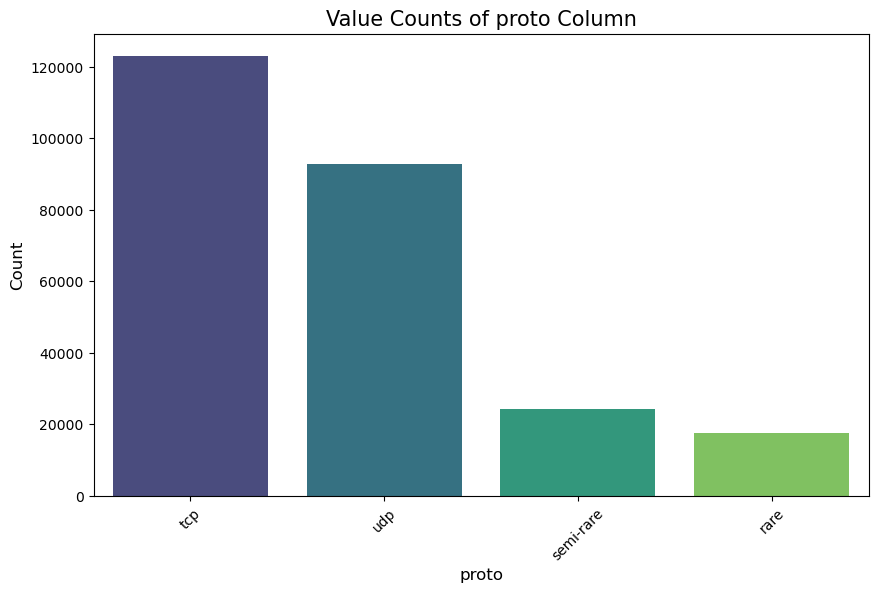

In [11]:
plot_value_counts('proto')

### 2. Service Type

In [12]:
service_counts = merged_df["service"].value_counts()

In [13]:
rare_services = service_counts[service_counts < 10000].index
merged_df['service'] = merged_df['service'].replace(rare_services, 'rare')

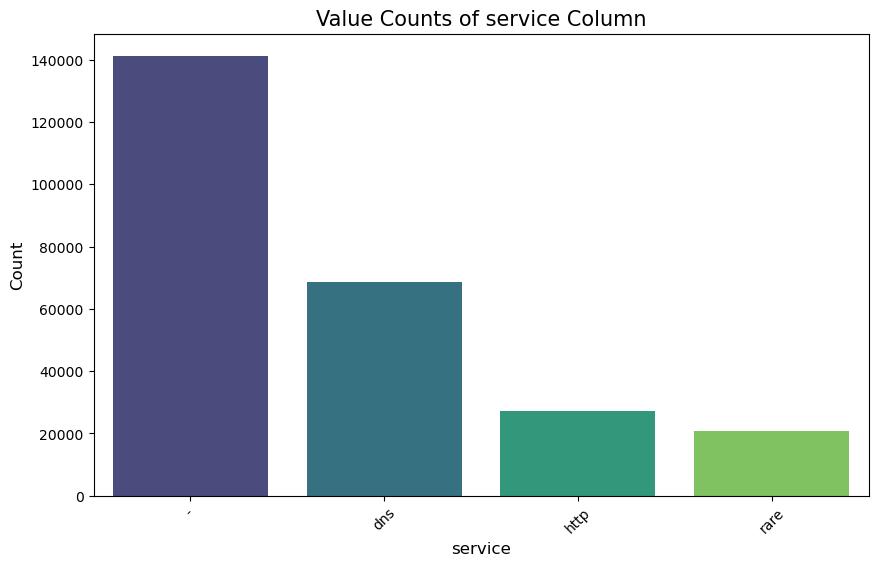

In [14]:
plot_value_counts('service')

### 3. State

In [15]:
merged_df["state"].value_counts()

FIN    117164
INT    116438
CON     20134
REQ      3833
RST        84
ECO        12
ACC         4
CLO         1
PAR         1
URN         1
no          1
Name: state, dtype: int64

In [16]:
merged_df['state'] = merged_df['state'].replace(['REQ', 'RST', 'ECO', 'ACC', 'CLO', 'PAR', 'URN', 'no'], 'Other')

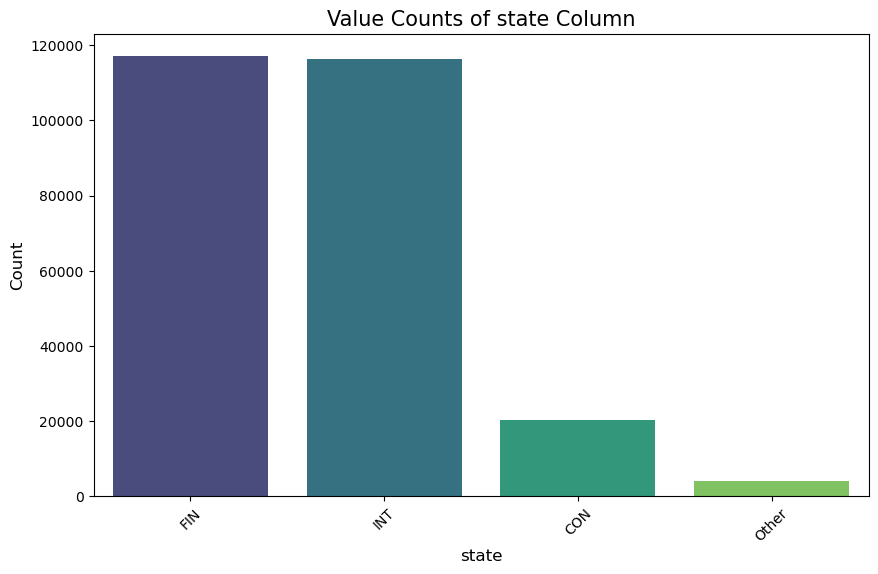

In [17]:
plot_value_counts('state')

### 4. Attack Category

In [18]:
attack_cat_counts = merged_df["attack_cat"].value_counts()
attack_cat_counts

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

In [19]:
rare_attacks = attack_cat_counts[attack_cat_counts < 10000].index
merged_df['attack_cat'] = merged_df['attack_cat'].replace(rare_attacks, 'rare')

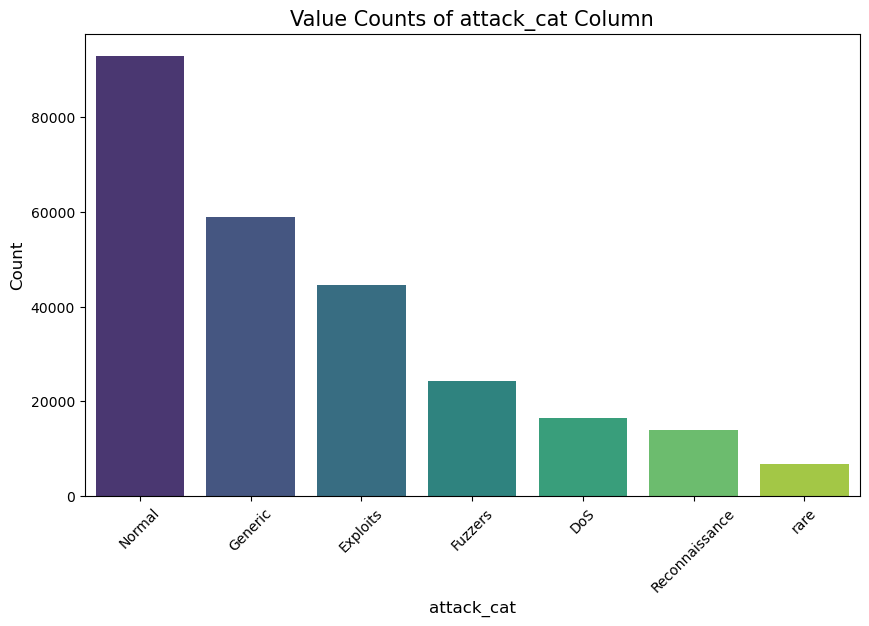

In [20]:
plot_value_counts('attack_cat')

### One- Hot Encode the Categorical Columns

In [21]:
categorical_columns = ['state', 'service', 'proto', 'attack_cat']

merged_df_encoded = pd.get_dummies(merged_df, columns=categorical_columns, drop_first=True)

merged_df_encoded.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_rare,proto_semi-rare,proto_tcp,proto_udp,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_rare
0,1,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,...,0,0,0,1,0,0,0,1,0,0
1,2,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,...,0,0,0,1,0,0,0,1,0,0
2,3,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,...,0,0,0,1,0,0,0,1,0,0
3,4,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,...,0,0,0,1,0,0,0,1,0,0
4,5,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,...,0,0,0,1,0,0,0,1,0,0


In [22]:
merged_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 175340
Data columns (total 57 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         257673 non-null  int64  
 1   dur                        257673 non-null  float64
 2   spkts                      257673 non-null  int64  
 3   dpkts                      257673 non-null  int64  
 4   sbytes                     257673 non-null  int64  
 5   dbytes                     257673 non-null  int64  
 6   rate                       257673 non-null  float64
 7   sttl                       257673 non-null  int64  
 8   dttl                       257673 non-null  int64  
 9   sload                      257673 non-null  float64
 10  dload                      257673 non-null  float64
 11  sloss                      257673 non-null  int64  
 12  dloss                      257673 non-null  int64  
 13  sinpkt                     25

### Normalize the numerical columns

In [23]:
exclude_features = ["id", "label", "type"]

columns_to_normalize = [col for col in merged_df_encoded.columns if col not in exclude_features]

scaler = StandardScaler()
merged_df_encoded[columns_to_normalize] = scaler.fit_transform(merged_df_encoded[columns_to_normalize])

In [24]:
merged_df_encoded.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_rare,proto_semi-rare,proto_tcp,proto_udp,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_rare
0,1,-0.208678,-0.130765,-0.165331,-0.046480,-0.098409,-0.002151,0.722026,-0.751628,0.590935,...,-0.295398,-0.321877,-0.955984,1.334022,-0.457047,-0.322288,-0.544177,1.330668,-0.239578,-0.163277
1,2,-0.208679,-0.130765,-0.165331,-0.039194,-0.098409,0.210460,0.722026,-0.751628,4.363255,...,-0.295398,-0.321877,-0.955984,1.334022,-0.457047,-0.322288,-0.544177,1.330668,-0.239578,-0.163277
2,3,-0.208679,-0.130765,-0.165331,-0.043188,-0.098409,0.678204,0.722026,-0.751628,4.220037,...,-0.295398,-0.321877,-0.955984,1.334022,-0.457047,-0.322288,-0.544177,1.330668,-0.239578,-0.163277
3,4,-0.208679,-0.130765,-0.165331,-0.044155,-0.098409,0.470318,0.722026,-0.751628,2.850314,...,-0.295398,-0.321877,-0.955984,1.334022,-0.457047,-0.322288,-0.544177,1.330668,-0.239578,-0.163277
4,5,-0.208678,-0.130765,-0.165331,-0.037100,-0.098409,0.054546,0.722026,-0.751628,4.198501,...,-0.295398,-0.321877,-0.955984,1.334022,-0.457047,-0.322288,-0.544177,1.330668,-0.239578,-0.163277


### Find the correlation of all the attributes with the target attribute "label"

Features correlated with label (positive and negative):
id                           0.490584
rate                         0.335883
sttl                         0.624082
sload                        0.165249
dload                       -0.352169
sinpkt                      -0.155454
swin                        -0.364877
stcpb                       -0.266585
dtcpb                       -0.263543
dwin                        -0.339166
dmean                       -0.295173
ct_srv_src                   0.246596
ct_state_ttl                 0.476559
ct_dst_ltm                   0.240776
ct_src_dport_ltm             0.318518
ct_dst_sport_ltm             0.371672
ct_dst_src_ltm               0.299609
ct_src_ltm                   0.252498
ct_srv_dst                   0.247812
is_sm_ips_ports             -0.160126
label                        1.000000
state_FIN                   -0.309305
state_INT                    0.516735
service_dns                  0.259911
proto_semi-rare              0.1

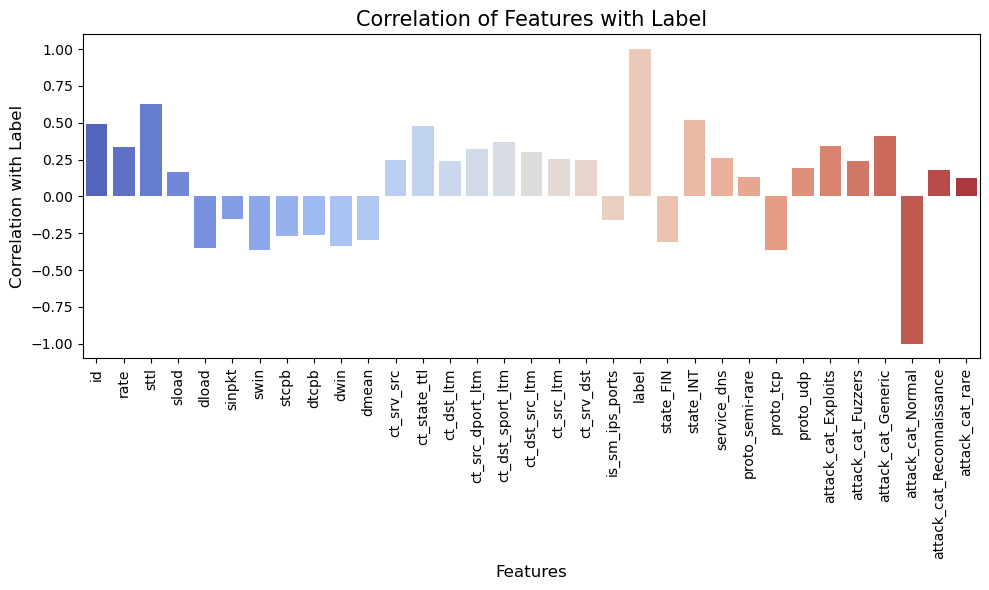

In [25]:
# Select only numeric columns to avoid the warning
numeric_df = merged_df_encoded.select_dtypes(include=[np.number])

# Compute the correlation matrix using only numeric columns
correlation_matrix = numeric_df.corr()

# Correlation with respect to the target variable "label"
label_correlation = correlation_matrix["label"]

# Set a correlation threshold to filter features (for both positive and negative correlations)
correlation_threshold = 0.1  # Adjust this threshold based on how strict you want to be

# Keep only features that have an absolute correlation greater than the threshold
correlated_features = label_correlation[abs(label_correlation) > correlation_threshold]

# Display the correlated features (both positive and negative)
print("Features correlated with label (positive and negative):")
print(correlated_features)

# Plotting a 1D barplot of correlation with 'label'
plt.figure(figsize=(10, 6))
sns.barplot(x=correlated_features.index, y=correlated_features.values, palette='coolwarm')

# Adding labels and title
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation with Label', fontsize=12)
plt.title('Correlation of Features with Label', fontsize=15)
plt.xticks(rotation=90)  # Rotate feature names to fit the plot
plt.tight_layout()
plt.show()

### Filter out features with low correlation

In [26]:
train_data = merged_df_encoded[merged_df_encoded["type"] == "train"]
test_data = merged_df_encoded[merged_df_encoded["type"] == "test"]

correlated_features_list = correlated_features.index.tolist()


X_train = train_data[correlated_features_list].drop(columns=['id', 'label'])
y_train = train_data['label']

X_test = test_data[correlated_features_list].drop(columns=['id', 'label'])
y_test = test_data['label']

In [27]:
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape},  {y_test.shape}")

Train data shape: (82332, 31), (82332,)
Test data shape: (175341, 31),  (175341,)


## Build the Auto Encoder Model

Autoencoder Structure: An autoencoder consists of an encoder part that compresses the input into a lower-dimensional representation and a decoder part that reconstructs the input from this representation.
The output of an autoencoder is typically shaped like the input data, hence it retains the same dimensionality (or features) as the input data.

*Used for Dimensionality Reduction*

In [28]:
# Define the autoencoder model
input_dim = X_train.shape[1]  # Input size (number of features)

# Encoding layers
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer) 
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(16, activation='relu')(encoded)  # Latent space

decoded = Dense(32, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
ecoded = Dense(256, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Build the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mae')

## Use callbacks to train the AutoEncoder

In [29]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          
    patience=5,                  
    restore_best_weights=True    
)

model_checkpoint = ModelCheckpoint(
    'autoencoder_best_model.keras',  
    monitor='val_loss',            
    save_best_only=True,          
    mode='min'                    
)

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=128, 
                          shuffle=True, 
                          validation_split = 0.2,
                          verbose=1,
                          callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.7517 - val_loss: 0.5175
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5783 - val_loss: 0.5227
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5644 - val_loss: 0.5140
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5567 - val_loss: 0.5129
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5515 - val_loss: 0.5103
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5486 - val_loss: 0.5088
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5474 - val_loss: 0.5024
Epoch 8/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5453 - val_loss: 0.5003
Epoch 9/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5443 - val_loss: 0.4981
Epoch 10/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5418 - val_loss: 0.4999
Epoch 11/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.5394 - val_loss: 0.4993
Epoch 12/50
515/515 ━━━━━━━━━━━━━

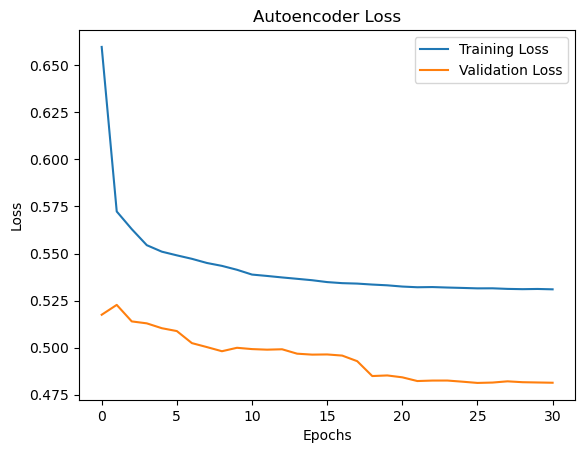

In [30]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Use the encoded features from train and test dataset

In [31]:
encoded_features_train = autoencoder.predict(X_train)
encoded_features_test = autoencoder.predict(X_test)

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


### Train on the Logistic Regression Model

In [32]:
classifier = LogisticRegression()
classifier.fit(encoded_features_train, y_train)

LogisticRegression()

In [33]:
y_pred = classifier.predict(encoded_features_test)

### Calculate the Accuracy, F1-Score and Area Under ROC Curve for the test data

In [34]:
print(f"Area under ROC curve: {roc_auc_score(y_test, y_pred) :.3f}")
print(f"F1-score: {f1_score(y_test, y_pred) :.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred) :.3f}")

Area under ROC curve: 0.955
F1-score: 0.978
Accuracy: 0.969


### Construct the Confusion Matrix

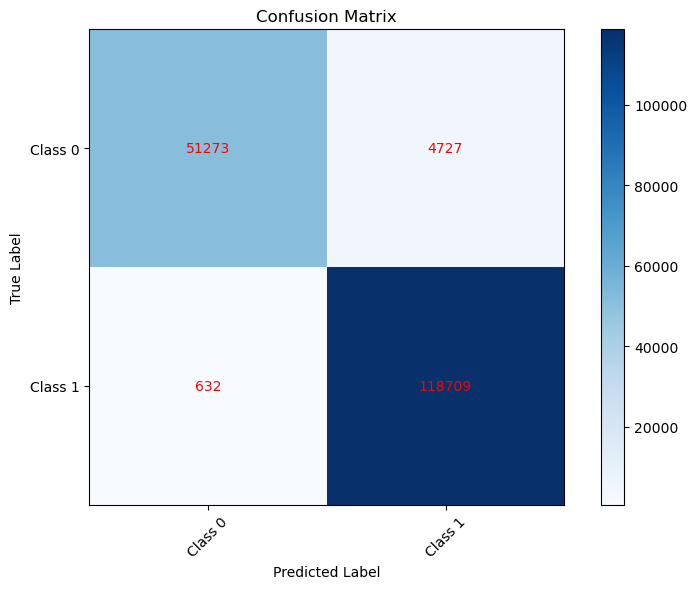

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.tight_layout()
plt.show()

### Use grid search to find the optimal threshold for the Logistic Regression Model

In [36]:
# parameter grid
param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# pipeline
pipeline = Pipeline([('classifier', classifier)])

# Define the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X_test)

### Calculate the metrics again

In [37]:
print(f"Area under ROC curve: {roc_auc_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Area under ROC curve: 1.0
F1-score: 1.0
Accuracy: 1.0


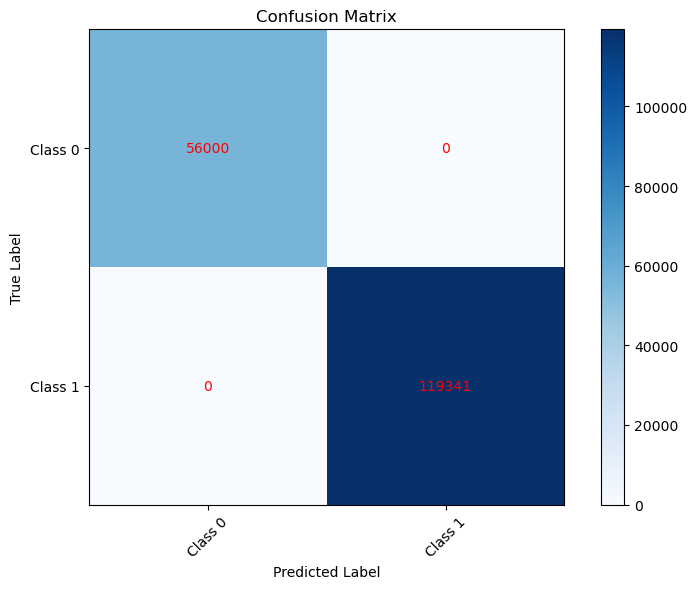

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.tight_layout()
plt.show()

## Anomaly detection in the train data

In [39]:
X_train_reconstructed = autoencoder.predict(X_train)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(X_train - X_train_reconstructed), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)

X_t_reconstructed = autoencoder.predict(X_train)

# Calculate reconstruction error
test_reconstruction_error = np.mean(np.square(X_train - X_train_reconstructed), axis=1)

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [40]:
# Anomaly detection
x_pred_anomalies = [1 if e > threshold else 0 for e in reconstruction_error]

# Analyze results
print("Number of anomalies detected:", sum(x_pred_anomalies))

Number of anomalies detected: 4117


### Remove anomalies from the train data

In [41]:
X_train['anomaly'] = x_pred_anomalies
X_train['label'] = y_train

# Filter out anomalies (where anomaly column is 1)
X_train_cleaned = X_train[X_train['anomaly'] == 0].drop(columns=['anomaly']) 

# Extract the cleaned feature set and labels
X_train_cleaned = X_train_cleaned.drop(columns=['label'])  # Cleaned X_train
y_train_cleaned = X_train[X_train['anomaly'] == 0]['label']

In [42]:
encoded_features_train = autoencoder.predict(X_train_cleaned)

2445/2445 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


In [43]:
classifier.fit(encoded_features_train, y_train_cleaned)

LogisticRegression()

### Check the performance after anomaly removal

In [44]:
y_pred = classifier.predict(encoded_features_test)

In [45]:
print(f"Area under ROC curve: {roc_auc_score(y_test, y_pred) :.3f}")
print(f"F1-score: {f1_score(y_test, y_pred) :.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred) :.3f}")

Area under ROC curve: 0.945
F1-score: 0.963
Accuracy: 0.950
